In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)
    
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        lower_red1 = np.array([0, 100, 20])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([160, 100, 20])
        upper_red2 = np.array([179, 255, 255])
        
        lower_mask_red = cv2.inRange(image, lower_red1, upper_red1)
        upper_mask_red = cv2.inRange(image, lower_red2, upper_red2)
        red_mask = lower_mask_red + upper_mask_red
        red_mask[red_mask != 0] = 1
        
        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2
        
        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1)
        full_mask = full_mask.astype(np.uint8)
        
        return full_mask
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.read_mask(label_path)
        image = cv2.resize(image, self.resize)
        
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
        
        return image, label

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class PartialDecoder(nn.Module):
    def __init__(self, in_channels_list, num_classes, reduced_channels=64):
        super(PartialDecoder, self).__init__()
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_ch, reduced_channels, kernel_size=1)
            for in_ch in in_channels_list
        ])
        self.final_conv = nn.Conv2d(reduced_channels * len(in_channels_list), num_classes, kernel_size=3, padding=1)
        
    def forward(self, *features):
        target_size = features[0].shape[2:]
        outs = []
        for conv, f in zip(self.conv_layers, features):
            f_conv = conv(f)
            f_up = F.interpolate(f_conv, size=target_size, mode='bilinear', align_corners=True)
            outs.append(f_up)
        concat = torch.cat(outs, dim=1)
        seg_map = self.final_conv(concat) 
        return seg_map

class ReverseAttention(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ReverseAttention, self).__init__()
        self.seg_proj = nn.Conv2d(num_classes, in_channels, kernel_size=1)
        self.conv = nn.Conv2d(in_channels, num_classes, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, high_level_feat, segmentation_map):
        seg_proj = self.seg_proj(segmentation_map) 
        seg_sigmoid = self.sigmoid(seg_proj)
        reverse_map = 1 - seg_sigmoid           
        attention = high_level_feat * reverse_map  
        out_seg = self.conv(attention) 
        refined_seg = segmentation_map + out_seg
        return refined_seg

class PraNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super(PraNet, self).__init__()
        resnet = models.resnet50(pretrained=True)

        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        # encoder2 [B, 256, H/4, W/4]
        self.encoder2 = resnet.layer1
        # encoder3: [B, 512, H/8, W/8]
        self.encoder3 = resnet.layer2
        # encoder4: [B, 1024, H/16, W/16]
        self.encoder4 = resnet.layer3
        # encoder5: [B, 2048, H/32, W/32]
        self.encoder5 = resnet.layer4

        self.pd = PartialDecoder(
            in_channels_list=[256, 512, 1024, 2048],
            num_classes=num_classes,
            reduced_channels=64
        )

        self.ra5 = ReverseAttention(in_channels=2048, num_classes=num_classes)
        self.ra4 = ReverseAttention(in_channels=1024, num_classes=num_classes)
        self.ra3 = ReverseAttention(in_channels=512, num_classes=num_classes)
        
    def forward(self, x):
        enc1 = self.encoder1(x)      # [B, 64, H/4, W/4]
        enc2 = self.encoder2(enc1)   # [B, 256, H/4, W/4]
        enc3 = self.encoder3(enc2)   # [B, 512, H/8, W/8]
        enc4 = self.encoder4(enc3)   # [B, 1024, H/16, W/16]
        enc5 = self.encoder5(enc4)   # [B, 2048, H/32, W/32]
        global_map = self.pd(enc2, enc3, enc4, enc5)  
        ra5_in = F.interpolate(global_map, size=enc5.shape[2:], mode='bilinear', align_corners=True)
        refined5 = self.ra5(enc5, ra5_in) 
        ra4_in = F.interpolate(refined5, size=enc4.shape[2:], mode='bilinear', align_corners=True)
        refined4 = self.ra4(enc4, ra4_in) 
        ra3_in = F.interpolate(refined4, size=enc3.shape[2:], mode='bilinear', align_corners=True)
        refined3 = self.ra3(enc3, ra3_in) 
        final_map = F.interpolate(refined3, size=x.shape[2:], mode='bilinear', align_corners=True)
        return final_map


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import os
import cv2
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

class IoULoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(IoULoss, self).__init__()
        self.eps = eps

    def forward(self, preds, targets):
        preds = F.softmax(preds, dim=1)  
        targets_one_hot = F.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2)  

        intersection = (preds * targets_one_hot).sum(dim=(2, 3)) 
        union = (preds + targets_one_hot).sum(dim=(2, 3)) - intersection
        iou = (intersection + self.eps) / (union + self.eps)
        return 1 - iou.mean()  

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
        self.iou_loss = IoULoss()

    def forward(self, preds, targets):
        ce = self.ce_loss(preds, targets)
        iou = self.iou_loss(preds, targets)
        return self.alpha * ce + (1 - self.alpha) * iou

train_transform = A.Compose([
    A.HorizontalFlip(p=0.4),
    A.VerticalFlip(p=0.4),
    A.RandomGamma(gamma_limit=(70, 130), p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

lr = 0.005
batch_size = 8
epochs = 150
in_channels = 3 
out_channels = 3 
H, W = 480, 480  

model = PraNet(num_classes=out_channels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_fn = CombinedLoss(alpha=0.5) 

class CustomDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self): 
        return len(self.images)
    
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        lower_red1 = np.array([0, 100, 20])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([160, 100, 20])
        upper_red2 = np.array([179, 255, 255])
        
        lower_mask_red = cv2.inRange(image, lower_red1, upper_red1)
        upper_mask_red = cv2.inRange(image, lower_red2, upper_red2)
        red_mask = lower_mask_red + upper_mask_red
        red_mask[red_mask != 0] = 1  # Class 1
        
        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2  # Class 2
        
        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = full_mask.astype(np.uint8)
        
        return full_mask
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.read_mask(label_path)
        image = cv2.resize(image, self.resize)
        
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].long() 
        
        return image, label

train_dataset = CustomDataset(
    img_dir='/kaggle/input/bkai-igh-neopolyp/train/train',
    label_dir='/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt',
    resize=(H, W),
    transform=train_transform,
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)

    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images) 
        loss = loss_fn(outputs, masks) 

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
    scheduler.step(epoch_loss)



KeyboardInterrupt: 

In [6]:
torch.save(model.state_dict(), "/kaggle/working/model_weights.pth")


<ipython-input-7-5f72780ba717>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/model_weights.pth", map_location=device))


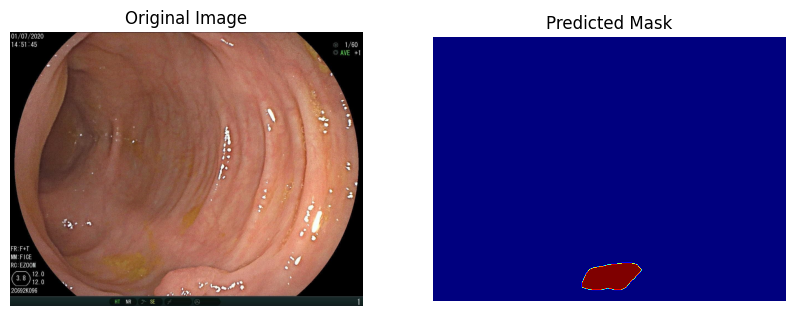

In [ ]:
def infer(model, image_path, device):
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = A.Compose([
        A.Resize(480, 640),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])(image=image)
    
    input_tensor = transformed['image'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap="jet")
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()
model = PraNet(num_classes=3).to(device) 
model.load_state_dict(torch.load("/kaggle/working/model_weights.pth", map_location=device))
model.eval()
device="cuda"
infer(model, "/kaggle/input/bkai-igh-neopolyp/train/train/0081835cf877e004e8bfb905b78a9139.jpeg", device)